In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [79]:
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NODES = 1000

In [3]:
df = pd.read_csv("../uci_data/OnlineNewsPopularity.csv")
print("calculating mean/median")
mean =  df[" shares"].mean()
median = df[" shares"].median()
print("mean: ", mean)
print("median: ", median)
[print(len(df))]

calculating mean/median
mean:  3395.3801836343455
median:  1400.0
39644


[None]

In [4]:
df.loc[df[' shares'] < median, ' shares'] = 0
df.loc[df[' shares'] >= median, ' shares'] = 1
df = df.iloc[:, 2:]

In [5]:
df.head()
len(df.columns)

59

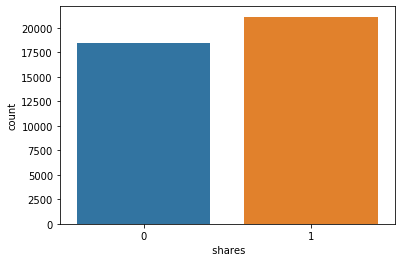

In [6]:
sns.countplot(x = ' shares', data=df)

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [8]:
X

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,...,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,...,0.374825,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000
39641,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,5.076923,...,0.307273,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364
39642,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,4.975073,...,0.236851,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000


In [9]:
y


0        0
1        0
2        1
3        0
4        0
        ..
39639    1
39640    1
39641    1
39642    0
39643    0
Name:  shares, Length: 39644, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [46]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [80]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [81]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 58.
        self.layer_1 = nn.Linear(58, NODES) 
        self.layer_2 = nn.Linear(NODES, NODES)
        self.layer_3 = nn.Linear(NODES, NODES)
        self.layer_4= nn.Linear(NODES, NODES)
        self.layer_out = nn.Linear(NODES, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(NODES)
        self.batchnorm2 = nn.BatchNorm1d(NODES)
        self.batchnorm3 = nn.BatchNorm1d(NODES)
        self.batchnorm4 = nn.BatchNorm1d(NODES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [83]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=58, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_4): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_out): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [84]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [85]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.66039 | Acc: 63.279
Epoch 002: | Loss: 0.61167 | Acc: 66.606
Epoch 003: | Loss: 0.60290 | Acc: 67.587
Epoch 004: | Loss: 0.59184 | Acc: 68.067
Epoch 005: | Loss: 0.58322 | Acc: 68.913
Epoch 006: | Loss: 0.57233 | Acc: 69.635
Epoch 007: | Loss: 0.55725 | Acc: 70.962
Epoch 008: | Loss: 0.54488 | Acc: 71.625
Epoch 009: | Loss: 0.52243 | Acc: 73.356
Epoch 010: | Loss: 0.50960 | Acc: 74.135
Epoch 011: | Loss: 0.48391 | Acc: 75.981
Epoch 012: | Loss: 0.45588 | Acc: 77.769
Epoch 013: | Loss: 0.42766 | Acc: 79.279
Epoch 014: | Loss: 0.39070 | Acc: 81.548
Epoch 015: | Loss: 0.35392 | Acc: 83.558
Epoch 016: | Loss: 0.30813 | Acc: 86.106
Epoch 017: | Loss: 0.27973 | Acc: 87.606
Epoch 018: | Loss: 0.25027 | Acc: 89.058
Epoch 019: | Loss: 0.21046 | Acc: 91.000
Epoch 020: | Loss: 0.19261 | Acc: 91.904
Epoch 021: | Loss: 0.16147 | Acc: 93.337
Epoch 022: | Loss: 0.14403 | Acc: 94.144
Epoch 023: | Loss: 0.12276 | Acc: 94.885
Epoch 024: | Loss: 0.11840 | Acc: 95.212
Epoch 025: | Los

In [86]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [87]:
confusion_matrix(y_test, y_pred_list)


array([[3468, 2539],
       [2594, 4482]], dtype=int64)

In [88]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.57      0.58      0.57      6007
           1       0.64      0.63      0.64      7076

    accuracy                           0.61     13083
   macro avg       0.61      0.61      0.61     13083
weighted avg       0.61      0.61      0.61     13083

